<a href="https://colab.research.google.com/github/B51454511/Comparing-different-breathing-strategies-VSB-and-VFB-in-sport-according-to-the-physical-performance/blob/main/code_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow tensorflow-hub

In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, hilbert, find_peaks, medfilt
import tensorflow as tf
import tensorflow_hub as hub
import csv


/tmp/ipython-input-13997490.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=target_sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-13997490.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=target_sr, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-13997490.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=target_sr, mono=True)
/usr/local/lib/python

Loaded Slow Group: (11, 124416)
Loaded Fast Group: (11, 122880)
Slow Group Heart Rates: [ 96.68063165  71.96093549 113.36327626  72.87554765 115.19198664
 126.35801437 128.90347464 134.65244764 104.49110821 109.10257782
  58.7500918 ]
Fast Group Heart Rates: [ 52.7462447   80.69692801  91.37412628 127.12187598  87.96821793
  64.7144475  102.76807719  88.29325976 124.74116209 131.56329146
 113.07759522]
Slow Group Breathing Rates: [13.5588843   8.15217391 25.07716049 17.72584034 12.24347015 20.5078125
 23.83474576 18.02884615 22.55491632 17.578125   21.484375  ]
Fast Group Breathing Rates: [24.97438525 26.46169355 21.63461538 23.93617021 20.625      15.49586777
 17.77251185 17.72584034 22.64968487 23.4375     22.84163136]


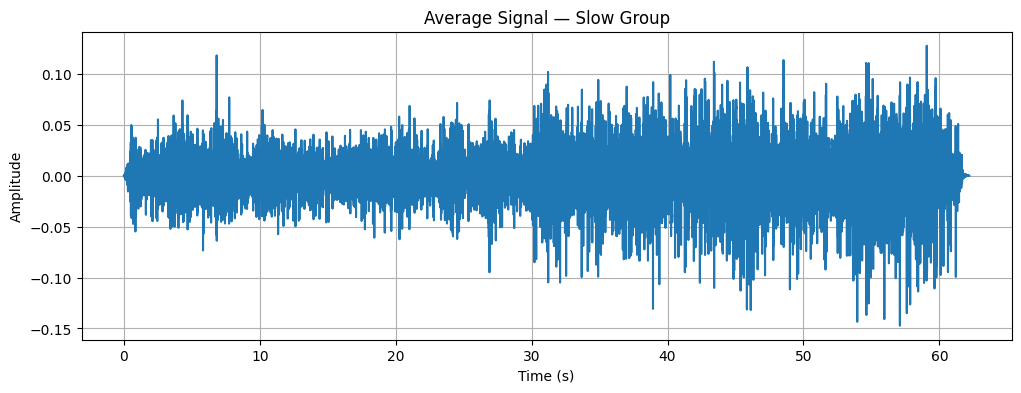

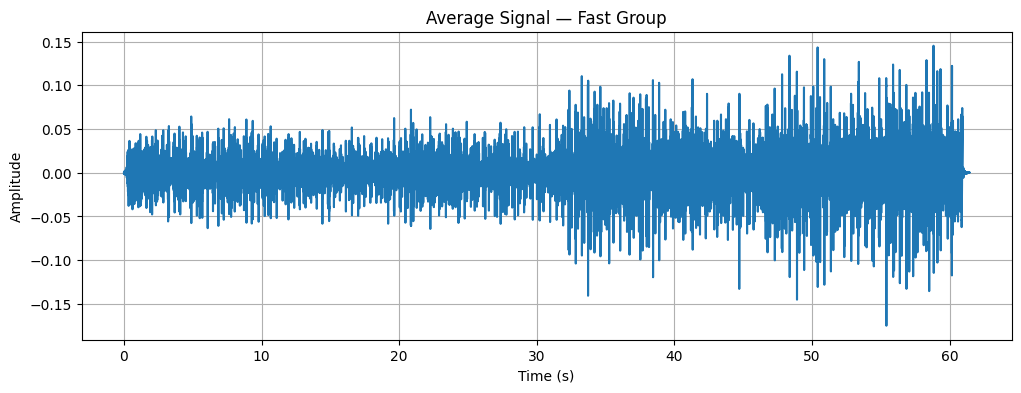

/tmp/ipython-input-13997490.py:282: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([slow_vals, fast_vals], labels=["Slow", "Fast"])


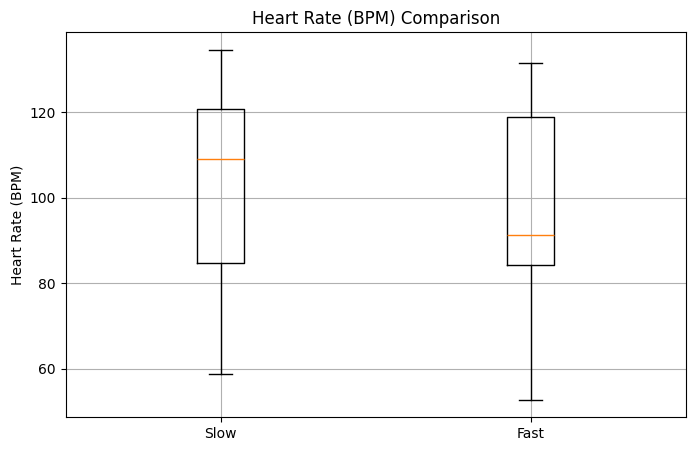

/tmp/ipython-input-13997490.py:282: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([slow_vals, fast_vals], labels=["Slow", "Fast"])


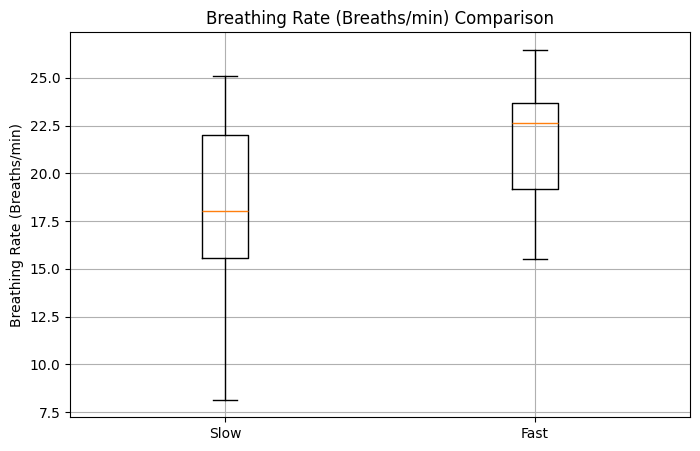

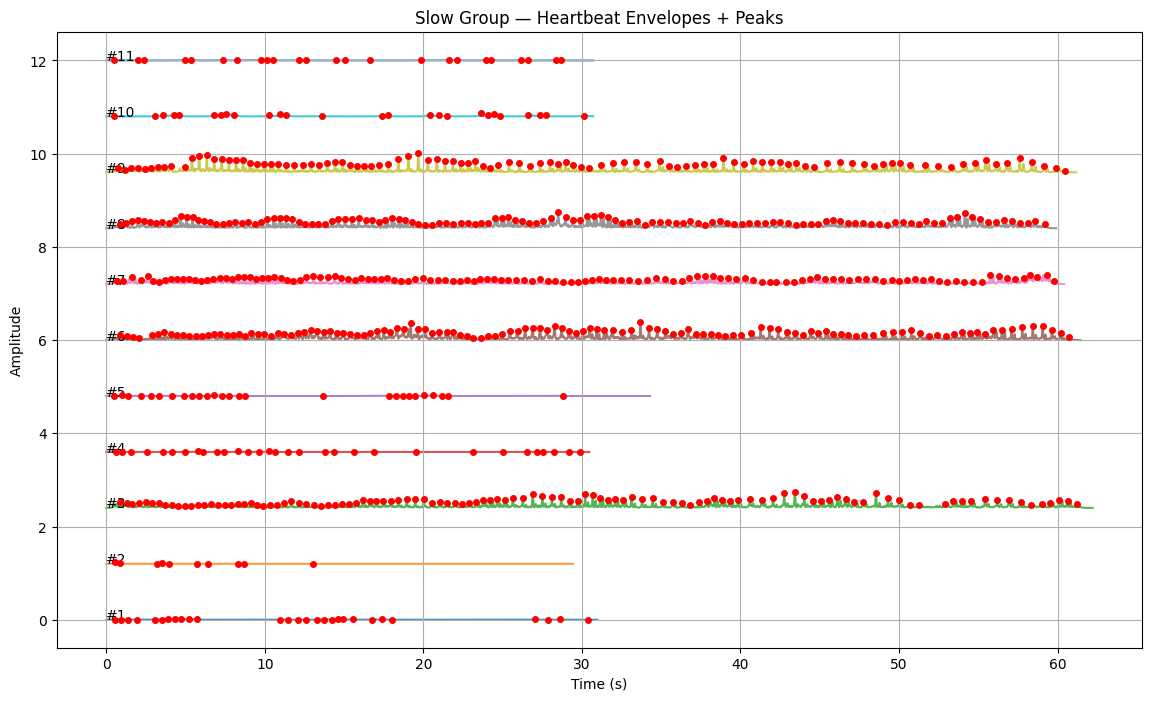

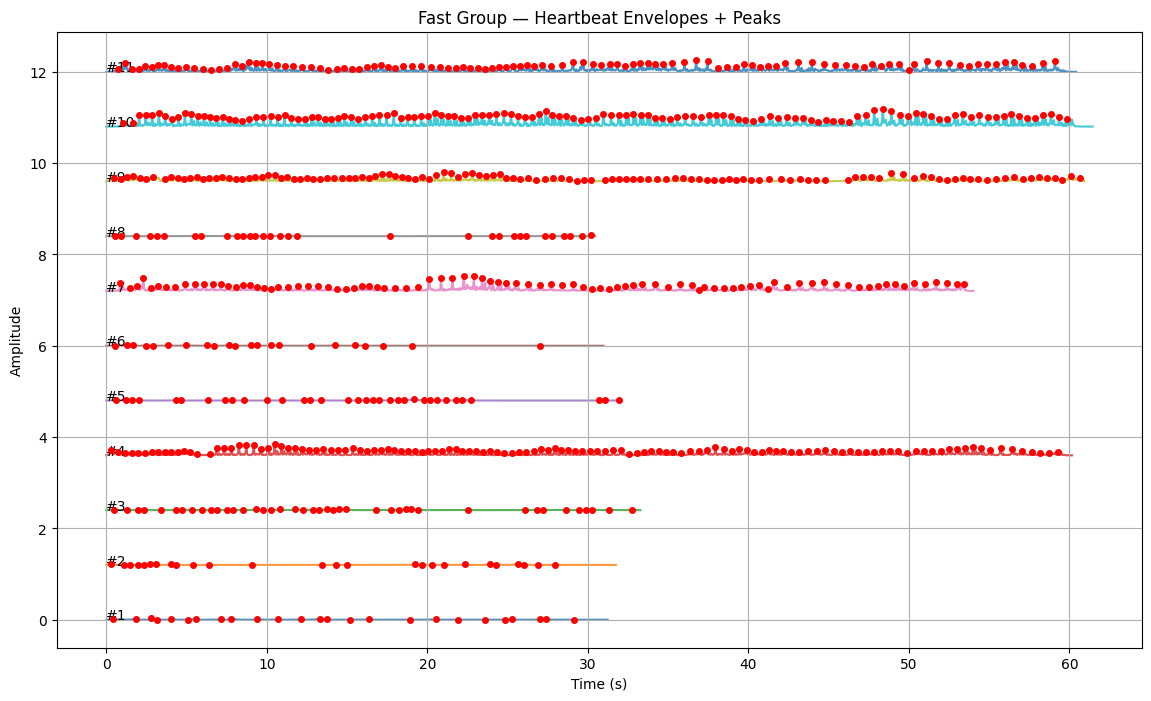

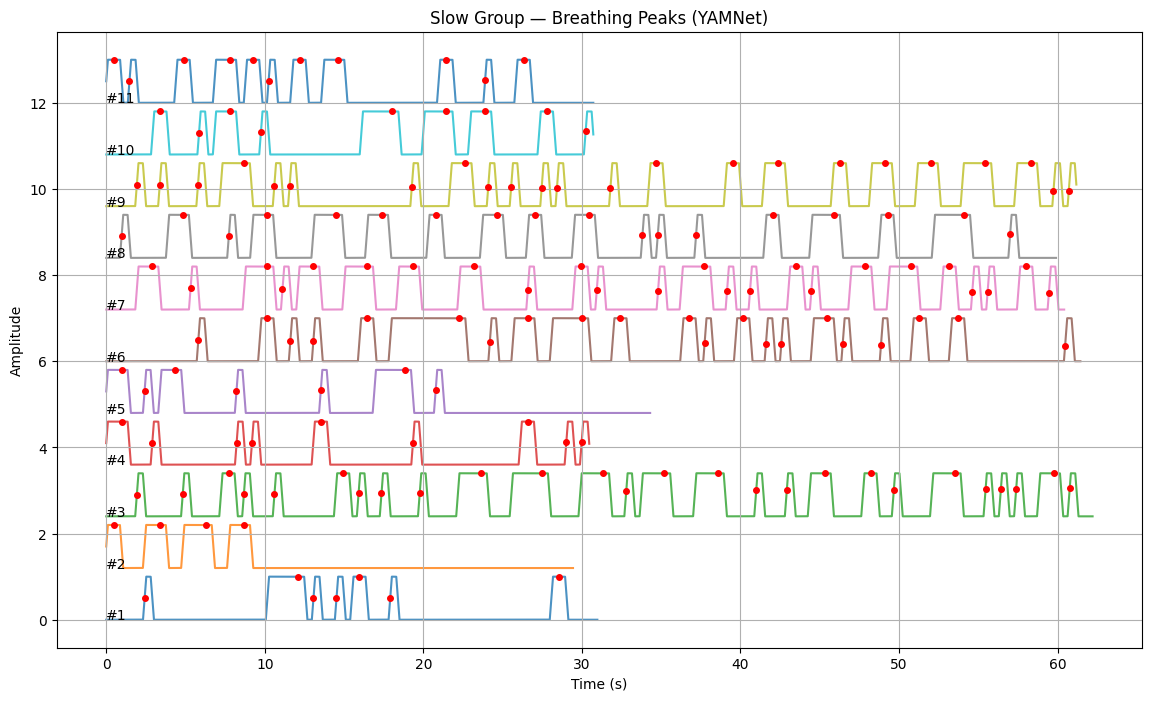

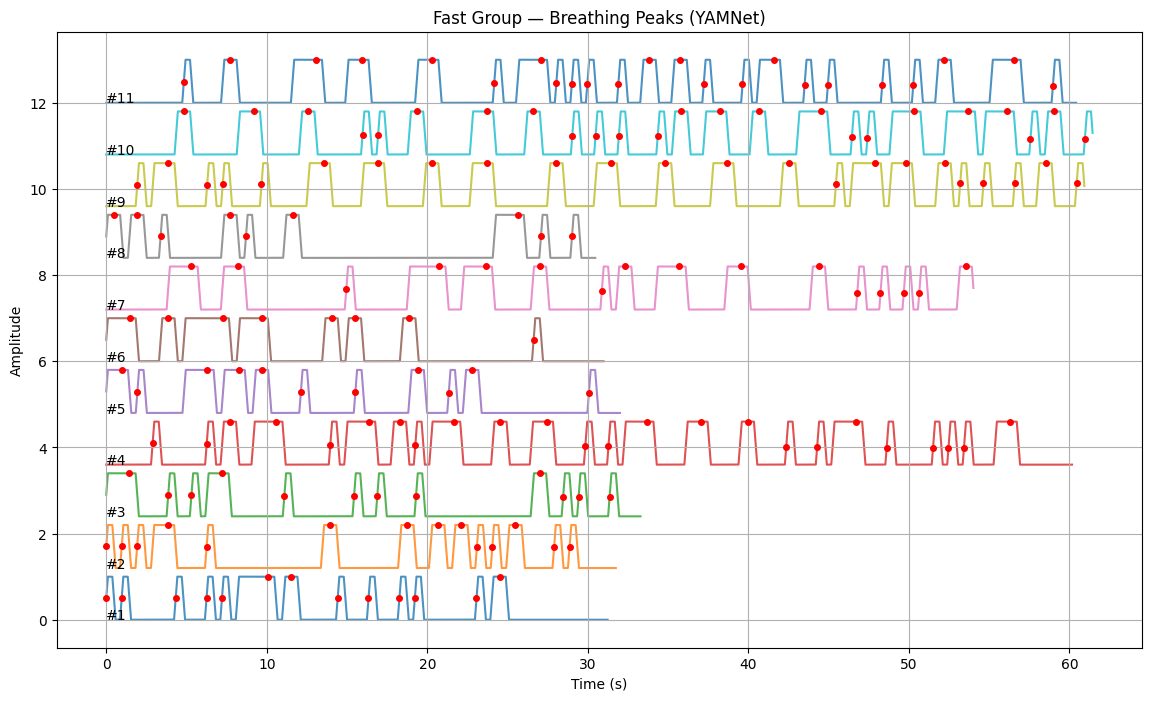

In [ ]:

# ==============================================================
# Utility functions
# ==============================================================

def load_and_trim_audio(path, target_sr=2000):
    """Load audio, convert to mono, normalize, remove silence."""
    y, sr = librosa.load(path, sr=target_sr, mono=True)

    # Normalize
    if np.max(np.abs(y)) > 0:
        y = y / np.max(np.abs(y))

    # Auto-trim silence
    y_trim, _ = librosa.effects.trim(y, top_db=25)

    return y_trim, sr


def pad_signals_to_same_length(signal_list):
    max_len = max(len(s) for s in signal_list)
    mat = np.full((len(signal_list), max_len), np.nan)

    for i, sig in enumerate(signal_list):
        mat[i, :len(sig)] = sig

    return mat

# ==============================================================
# Noise reduction
# ==============================================================

def spectral_gate_noise_reduction(y, sr):
    """Simple spectral gating noise reduction using librosa."""
    S = np.abs(librosa.stft(y))
    noise_profile = np.mean(S[:, :10], axis=1, keepdims=True)
    S_denoised = np.maximum(S - noise_profile, 0)
    y_clean = librosa.istft(S_denoised * np.exp(1j * np.angle(librosa.stft(y))))
    return y_clean


def smooth_signal(y, kernel=5):
    """Use a small median filter to remove spike noise."""
    return medfilt(y, kernel)


# ==============================================================
# Filtering and envelope
# ==============================================================

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = fs * 0.5
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    return b, a

def bandpass_filter(y, low, high, fs, order=4):
    b, a = butter_bandpass(low, high, fs, order)
    return filtfilt(b, a, y)

def envelope_hilbert(y, fs, smoothing=0.05):
    analytic = hilbert(y)
    env = np.abs(analytic)

    win = int(fs * smoothing)
    win = max(1, win)
    smooth_env = np.convolve(env, np.ones(win)/win, mode='same')
    return smooth_env


# ==============================================================
# Heartbeat Detection
# ==============================================================

def estimate_heart_rate(env, fs, min_hr=40, max_hr=180):
    min_dist = int(fs * 60 / max_hr)

    peaks, _ = find_peaks(env,
                          distance=min_dist,
                          prominence=np.mean(env) * 0.5)

    if len(peaks) < 2:
        return peaks, np.nan

    intervals = np.diff(peaks) / fs
    valid = intervals[(intervals > 0.3) & (intervals < 2.0)]

    if len(valid) == 0:
        return peaks, np.nan

    bpm = 60.0 / np.mean(valid)
    return peaks, bpm

# ==============================================================
# Breathing Detection (0.1–2 Hz, adaptive)
# ==============================================================

def detect_breaths(y, fs):
    """Breathing detection : low frequency extraction + envelope."""
    low = 0.1
    high = 2.0
    filtered = bandpass_filter(y, low, high, fs)

    env = envelope_hilbert(filtered, fs, smoothing=1.0)

    threshold = np.mean(env) + 0.4 * np.std(env)

    peaks, _ = find_peaks(env, distance=fs*2.0)  # <= 30 breaths/min
    peaks = [p for p in peaks if env[p] > threshold]

    brpm = len(peaks) * 60 / (len(y)/fs)
    return np.array(peaks), brpm, env

# ==============================================================
# YAMNet integration (needs resample to 16k)
# ==============================================================
_YAMNET_MODEL = None
_YAMNET_CLASSNAMES = None

def _load_yamnet():
    global _YAMNET_MODEL, _YAMNET_CLASSNAMES
    if _YAMNET_MODEL is None:
        # Load model
        _YAMNET_MODEL = hub.load("https://tfhub.dev/google/yamnet/1")
        # load class map bundled with model
        class_map_path = _YAMNET_MODEL.class_map_path().numpy().decode('utf-8')
        with tf.io.gfile.GFile(class_map_path) as csvfile:
            reader = csv.DictReader(csvfile)
            _YAMNET_CLASSNAMES = [row['display_name'] for row in reader]
    return _YAMNET_MODEL, _YAMNET_CLASSNAMES


# ==============================================================
# Group Loading
# ==============================================================

def load_group(folder, prefix):
    """Load all audio files whose name starts with prefix."""
    signals = []
    sample_rates = []

    for fname in os.listdir(folder):
        if fname.lower().startswith(prefix.lower()):
            path = os.path.join(folder, fname)
            y, sr = load_and_trim_audio(path)
            y = spectral_gate_noise_reduction(y, sr)
            y = smooth_signal(y)
            signals.append(y)
            sample_rates.append(sr)

    if not signals:
        return None, None

    mat = pad_signals_to_same_length(signals)
    return mat, sample_rates[0]


# ==============================================================
# Batch Processing + NEW: collect peaks & envelopes
# ==============================================================


def process_group(group, fs):
    """
    Process a group of signals.

    Heart rate: envelope + peak detection
    Breathing rate: YAMNet only
    Returns:
        heart_rates, breath_rates,
        heart_envs, heart_peaks_list,
        breath_envs, breath_peaks_list
    """
    heart_rates = []
    breath_rates = []
    heart_envs = []
    heart_peaks_list = []
    breath_envs = []
    breath_peaks_list = []

    for row in group:
        # Remove NaN padding
        valid = row[~np.isnan(row)]
        if len(valid) < 10:
            # Skip very short signals
            heart_rates.append(np.nan)
            breath_rates.append(np.nan)

            heart_envs.append(np.zeros(len(row)))
            breath_envs.append(np.zeros(len(row)))

            heart_peaks_list.append(np.array([]))
            breath_peaks_list.append(np.array([]))
            continue

        # -----------------------------
        # Heart rate detection
        # -----------------------------
        h_filtered = bandpass_filter(valid, 20, 60, fs)
        h_env = envelope_hilbert(h_filtered, fs)
        h_peaks, bpm = estimate_heart_rate(h_env, fs)

        # Pad heart envelope
        h_env_full = np.full(len(row), np.nan)
        h_env_full[:len(h_env)] = h_env

        heart_rates.append(bpm)
        heart_envs.append(h_env_full)
        heart_peaks_list.append(h_peaks)

        # -----------------------------
        # Breathing detection — YAMNet
        # -----------------------------
        try:
            b_peaks, brpm, b_env = detect_breaths_yamnet(valid, fs)
        except Exception:
            b_peaks = np.array([], dtype=int)
            brpm = np.nan
            b_env = np.zeros(len(valid))

        # Pad breathing envelope
        b_env_full = np.full(len(row), np.nan)
        b_env_full[:len(b_env)] = b_env

        breath_rates.append(brpm)
        breath_envs.append(b_env_full)
        breath_peaks_list.append(b_peaks)

    return (
        np.array(heart_rates),
        np.array(breath_rates),
        heart_envs, heart_peaks_list,
        breath_envs, breath_peaks_list
    )



# ==============================================================
# Plotting each processed signal + peaks
# ==============================================================

def plot_group_signals_with_peaks(group, env_list, peaks_list, fs, title):
    t = np.arange(group.shape[1]) / fs

    plt.figure(figsize=(14, 8))
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    for i, env in enumerate(env_list):
        offset = i * 1.2  # vertical spacing
        plt.plot(t, env + offset, alpha=0.8, zorder=1)

        peaks = peaks_list[i]
        if len(peaks) > 0:
            plt.plot(t[peaks], env[peaks] + offset, "ro", markersize=4, zorder=10)

        plt.text(0, offset, f"#{i+1}", fontsize=10)

    plt.grid(True)
    plt.show()


# ==============================================================
# Plot averages
# ==============================================================

def plot_avg_signal(group, fs, title):
    #avg = group.mean(axis=0)
    avg = np.nanmean(group, axis=0)
    t = np.arange(len(avg)) / fs

    plt.figure(figsize=(12,4))
    plt.plot(t, avg)
    plt.title(f"Average Signal — {title}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()


def plot_group_stats(slow_vals, fast_vals, metric_name):
    plt.figure(figsize=(8,5))
    plt.boxplot([slow_vals, fast_vals], labels=["Slow", "Fast"])
    plt.title(f"{metric_name} Comparison")
    plt.ylabel(metric_name)
    plt.grid(True)
    plt.show()


# ==============================================================
# MAIN EXECUTION
# ==============================================================

folder = "./"

slow_group, sr = load_group(folder, "slow")
fast_group, _ = load_group(folder, "fast")

print("Loaded Slow Group:", slow_group.shape if slow_group is not None else None)
print("Loaded Fast Group:", fast_group.shape if fast_group is not None else None)


(
    slow_hr, slow_br,
    slow_h_envs, slow_h_peaks,
    slow_b_envs, slow_b_peaks
) = process_group(slow_group, sr)

(
    fast_hr, fast_br,
    fast_h_envs, fast_h_peaks,
    fast_b_envs, fast_b_peaks
) = process_group(fast_group, sr)

print("Slow Group Heart Rates:", slow_hr)
print("Fast Group Heart Rates:", fast_hr)

print("Slow Group Breathing Rates:", slow_br)
print("Fast Group Breathing Rates:", fast_br)


# ==============================================================
# Average plots + Stats
# ==============================================================

plot_avg_signal(slow_group, sr, "Slow Group")
plot_avg_signal(fast_group, sr, "Fast Group")

plot_group_stats(slow_hr, fast_hr, "Heart Rate (BPM)")
plot_group_stats(slow_br, fast_br, "Breathing Rate (Breaths/min)")

# ==============================================================
# Plot all processed heartbeat signals + peaks
# ==============================================================

plot_group_signals_with_peaks(
    slow_group, slow_h_envs, slow_h_peaks, sr,
    "Slow Group — Heartbeat Envelopes + Peaks"
)

plot_group_signals_with_peaks(
    fast_group, fast_h_envs, fast_h_peaks, sr,
    "Fast Group — Heartbeat Envelopes + Peaks"
)

# ==============================================================
# Plot all breathing envelopes + peaks
# ==============================================================

plot_group_signals_with_peaks(
    slow_group, slow_b_envs, slow_b_peaks, sr,
    "Slow Group — Breathing Peaks (YAMNet)"
)

plot_group_signals_with_peaks(
    fast_group, fast_b_envs, fast_b_peaks, sr,
    "Fast Group — Breathing Peaks (YAMNet)"
)

In [ ]:
print(yamnet_class_names)

['Speech', 'Child speech, kid speaking', 'Conversation', 'Narration, monologue', 'Babbling', 'Speech synthesizer', 'Shout', 'Bellow', 'Whoop', 'Yell', 'Children shouting', 'Screaming', 'Whispering', 'Laughter', 'Baby laughter', 'Giggle', 'Snicker', 'Belly laugh', 'Chuckle, chortle', 'Crying, sobbing', 'Baby cry, infant cry', 'Whimper', 'Wail, moan', 'Sigh', 'Singing', 'Choir', 'Yodeling', 'Chant', 'Mantra', 'Child singing', 'Synthetic singing', 'Rapping', 'Humming', 'Groan', 'Grunt', 'Whistling', 'Breathing', 'Wheeze', 'Snoring', 'Gasp', 'Pant', 'Snort', 'Cough', 'Throat clearing', 'Sneeze', 'Sniff', 'Run', 'Shuffle', 'Walk, footsteps', 'Chewing, mastication', 'Biting', 'Gargling', 'Stomach rumble', 'Burping, eructation', 'Hiccup', 'Fart', 'Hands', 'Finger snapping', 'Clapping', 'Heart sounds, heartbeat', 'Heart murmur', 'Cheering', 'Applause', 'Chatter', 'Crowd', 'Hubbub, speech noise, speech babble', 'Children playing', 'Animal', 'Domestic animals, pets', 'Dog', 'Bark', 'Yip', 'Howl'

In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, hilbert, find_peaks, medfilt
import tensorflow as tf
import tensorflow_hub as hub
import csv


# Load YAMNet
yamnet_model = hub.load("https://tfhub.dev/google/yamnet/1")

# Get class names from YAMNet model
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
with tf.io.gfile.GFile(class_map_path) as csvfile:
    reader = csv.DictReader(csvfile)
    yamnet_class_names = [row['display_name'] for row in reader]

# YAMNet class index for "Speech" (which can include breathing in a general context)
# Original code used `YAMNET_BREATH_ID = 0`, which corresponds to "Speech".
# We will use this to ensure the label is explicit.
# Check if 'Speech' exists, otherwise use the original index 0.
try:
    YAMNET_CLASS_ID = yamnet_class_names.index('Wind')
    #print(f"Found 'Breathing' class with index {YAMNET_CLASS_ID}.")
except ValueError:
    print("Warning: 'Breathing' class not found in YAMNet output. Defaulting to index 0.")
    YAMNET_CLASS_ID = 0

def detect_breaths_yamnet(y_clean, sr):
    """
    Improved breathing detector using YAMNet.
    - Automatically selects likely breathing-related classes from YAMNet's class names.
    - Uses a robust threshold (percentile-based) to avoid empty detections.
    - Computes frame duration from model outputs for correct mapping to original sample indices.
    Returns:
        peaks (np.array of sample indices at original sr),
        brpm (breaths per minute, or np.nan),
        env (float array same length as y_clean, 0..1 indicator-like envelope)
    """
    if len(y_clean) < 100:
        return np.array([], dtype=int), np.nan, np.zeros_like(y_clean)

    # ensure global model & class names are loaded
    global _YAMNET_MODEL, _YAMNET_CLASSNAMES
    if _YAMNET_MODEL is None or _YAMNET_CLASSNAMES is None:
        _load_yamnet()

    # Resample to 16k (YAMNet expects 16k)
    y_16k = librosa.resample(y_clean, orig_sr=sr, target_sr=16000).astype(np.float32)

    # Run YAMNet
    scores, embeddings, spectrogram = _YAMNET_MODEL(y_16k)
    scores = scores.numpy()  # shape: (num_frames, num_classes)
    if scores.ndim == 1:
        # ensure 2D
        scores = scores[np.newaxis, :]

    n_frames = scores.shape[0]
    total_duration = len(y_16k) / 16000.0
    if n_frames <= 0 or total_duration <= 0:
        return np.array([], dtype=int), np.nan, np.zeros_like(y_clean)

    # compute frame duration dynamically (seconds per frame)
    frame_dt = total_duration / n_frames  # robust instead of hard-coded 0.48s

    # choose breathing-related classes automatically
    candidate_indices = []
    lower_names = [cn.lower() for cn in _YAMNET_CLASSNAMES]
    keywords = ("breath", "sigh", "inhale", "exhal", "resp", "wind")
    for i, nm in enumerate(lower_names):
        if any(k in nm for k in keywords):
            candidate_indices.append(i)

    # fallback if nothing found: try some reasonable candidates
    if not candidate_indices:
        for fallback in ("breathing", "sigh", "speech", "wind"):
            try:
                candidate_indices.append(lower_names.index(fallback))
            except ValueError:
                pass

    # final fallback: just use column 0 (should rarely happen)
    if not candidate_indices:
        candidate_indices = [0]

    # sum probabilities across selected class columns to get a single "breath score"
    breath_prob = np.sum(scores[:, candidate_indices], axis=1)

    # make threshold robust:
    # use a percentile threshold + small margin, and ensure at least a minimal absolute threshold
    perc = max(60, 60)  # you can tweak percentile (60..80)
    thresh_percentile = np.percentile(breath_prob, perc)
    thresh = max(thresh_percentile, np.mean(breath_prob) + 0.25 * np.std(breath_prob), 0.01)

    active_frames = np.where(breath_prob > thresh)[0]
    if len(active_frames) == 0:
        # no breaths detected — return zeros-shaped envelope
        return np.array([], dtype=int), np.nan, np.zeros(len(y_clean))

    # Merge consecutive/nearby active frames into events (frame units)
    merged_frames = []
    if len(active_frames) > 0:
        current = active_frames[0]
        for f in active_frames[1:]:
            # if the gap is more than 1 frame, consider it a new event
            if f - current > 1:
                merged_frames.append(current)
            current = f
        merged_frames.append(current)

    # Convert merged frame indices to sample indices in ORIGINAL sr
    peaks = []
    for fi in merged_frames:
        t = fi * frame_dt              # seconds from start of resampled signal
        # map time back to original sample rate
        sample = int(round(t * sr))
        if 0 <= sample < len(y_clean):
            peaks.append(sample)
    peaks = np.array(peaks, dtype=int)

    # compute breaths-per-minute
    total_time_sec = len(y_clean) / float(sr)
    if total_time_sec > 0:
        # further merge peaks closer than 0.8s (avoid double-counting)
        if len(peaks) > 1:
            merged = []
            current = peaks[0]
            for p in peaks[1:]:
                if (p - current) / sr > 0.8:
                    merged.append(current)
                current = p
            merged.append(current)
            br_count = len(merged)
        else:
            br_count = len(peaks)
        brpm = br_count * 60.0 / total_time_sec
    else:
        brpm = np.nan

    # Build an upsampled "env" indicator for plotting
    # frame_env length = n_frames, 1 if breath_prob > thresh else 0
    frame_env = (breath_prob > thresh).astype(float)

    # Upsample frame_env to original sample rate by repeating each frame for frame_dt*sr samples.
    reps = max(1, int(np.round(frame_dt * sr)))
    env = np.repeat(frame_env, reps)

    # trim/pad env to len(y_clean)
    if len(env) < len(y_clean):
        env = np.pad(env, (0, len(y_clean) - len(env)), 'constant', constant_values=0)
    else:
        env = env[:len(y_clean)]

    # smooth env a bit to make plotting nicer (simple moving average)
    win = max(1, int(sr * 0.2))  # 200 ms smoothing
    env = np.convolve(env, np.ones(win)/win, mode='same')

    return peaks, brpm, env
